In [1]:
import numpy as np
import random
from imutils import paths 
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import tensorflow
from PIL import Image
tensorflow.compat.v1.logging.set_verbosity((tensorflow.compat.v1.logging.ERROR)) #comment while debugging
from tensorflow.keras.preprocessing import image_dataset_from_directory


In [2]:
#!git clone https://github.com/farhansiddiqui/cnn-class.git

In [3]:
base_path = "."
#base_path = "/content/cnn-class"

In [4]:
img_height = 96
img_width = 96

model = tensorflow.keras.Sequential([
  tensorflow.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tensorflow.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tensorflow.keras.layers.MaxPooling2D(),
  tensorflow.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tensorflow.keras.layers.MaxPooling2D(),
  tensorflow.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tensorflow.keras.layers.MaxPooling2D(),
  tensorflow.keras.layers.Flatten(),
  tensorflow.keras.layers.Dense(128, activation='relu'),
  tensorflow.keras.layers.Dense(1, activation='sigmoid')
])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 96, 96, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0

In [6]:
model.compile(
    optimizer=tensorflow.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [7]:
image_size = (img_height, img_width)
batch_size = 64


train_ds = image_dataset_from_directory(
    f"{base_path}/malaria/training",
    labels="inferred",
    image_size=image_size,
    batch_size=batch_size)


val_ds = image_dataset_from_directory(
    f"{base_path}/malaria/validation",
    labels="inferred",
    image_size=image_size,
    batch_size=batch_size)

test_ds = image_dataset_from_directory(
    f"{base_path}/malaria/testing",
    labels="inferred",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False)


Found 19842 files belonging to 2 classes.
Found 2204 files belonging to 2 classes.
Found 5512 files belonging to 2 classes.


In [8]:
es = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
epochs = 100
hist = model.fit( train_ds, epochs=epochs, validation_data=val_ds, callbacks = [es])

Epoch 1/100
311/311 [==============================] - 42s 134ms/step - loss: 0.5566 - accuracy: 0.7088 - val_loss: 0.2591 - val_accuracy: 0.9047
Epoch 2/100
311/311 [==============================] - 41s 133ms/step - loss: 0.1800 - accuracy: 0.9409 - val_loss: 0.1782 - val_accuracy: 0.9474
Epoch 3/100
311/311 [==============================] - 41s 133ms/step - loss: 0.1397 - accuracy: 0.9532 - val_loss: 0.1745 - val_accuracy: 0.9519
Epoch 4/100
311/311 [==============================] - 41s 133ms/step - loss: 0.1231 - accuracy: 0.9581 - val_loss: 0.1616 - val_accuracy: 0.9564
Epoch 5/100
311/311 [==============================] - 41s 133ms/step - loss: 0.1080 - accuracy: 0.9626 - val_loss: 0.1599 - val_accuracy: 0.9519
Epoch 6/100
311/311 [==============================] - 41s 133ms/step - loss: 0.0935 - accuracy: 0.9688 - val_loss: 0.1663 - val_accuracy: 0.9501
Epoch 7/100
311/311 [==============================] - 41s 133ms/step - loss: 0.0791 - accuracy: 0.9730 - val_loss: 0.2169 -

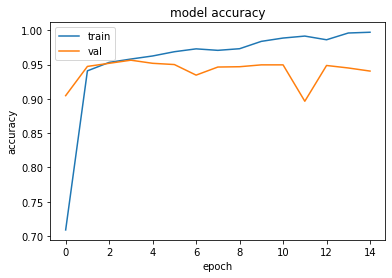

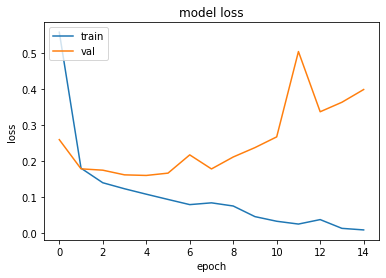

In [9]:

# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [10]:
imagePaths = list(paths.list_images(f'{base_path}/malaria/testing'))

C46P7ThinF_IMG_20151130_210938_cell_110.png


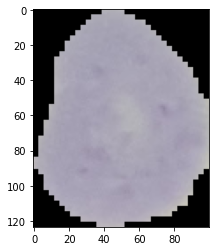

In [11]:
image = random.choice(imagePaths)
print(image.split('/')[-1].split('-')[0])
img = Image.open(image)
plt.imshow(img)

In [14]:
img = img.resize((img_height, img_width))
img_batch = np.expand_dims(np.asarray(img), axis=0)
prediction_class_idx = model.predict(img_batch)[0][0].round().astype('int32')
test_ds.class_names[prediction_class_idx]

'Uninfected'

In [15]:
def plot_confusion_matrix(cm, classes):
    cmap=plt.cm.Blues
    title='Confusion Matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

In [54]:
predictions = np.array([])
labels =  np.array([])
for x, y in test_ds:
    predictions = np.concatenate([predictions, model.predict_classes(x).flatten()])
    labels = np.concatenate([labels, y])

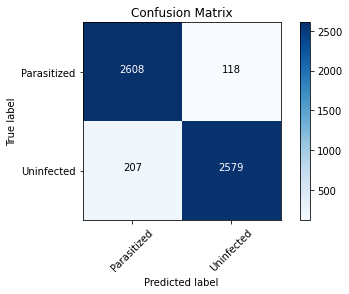

In [56]:
# predictions
cm = tensorflow.math.confusion_matrix(labels=labels, predictions=predictions).numpy()
plot_confusion_matrix(cm, test_ds.class_names)

In [57]:
#test accuracy 
round((labels == predictions).sum()/len(predictions),2)

0.94